In [80]:
import pandas as pd
import numpy as np

# 示例数据
data = {
    'Date': pd.date_range(start='2025-04-01', periods=30, freq='D'),
    'Open': [100 + i * 0.1 for i in range(30)],
    'High': [101 + i * 0.1 for i in range(30)],
    'Low': [99 - i * 0.1 for i in range(30)],
    'Close': [100 + i * 0.1 for i in range(30)]
}
df = pd.DataFrame(data)
df.set_index('Date', inplace=True)

In [81]:
import matplotlib.pyplot as plt
def plot(data):
    # 创建 x 轴数据（索引）
    x = np.arange(len(data))
    plt.plot(x, data, marker='o', linestyle='-', color='b')
    plt.xlabel("Index")
    plt.ylabel("Value")
    plt.grid(True)
    plt.legend()
    # 显示图形
    plt.show()

In [ ]:
import pandas as pd
import random,json
import numpy as np
from scipy.signal import find_peaks

# 
# 读取 Feather 文件
file_path = 'datas/BTC_USDT-1s.feather'
data = pd.read_feather(file_path)
with open("datas/BTC_trainning_index",'r')as f:
    s = f.read()
indexs = json.loads(s)


In [ ]:
with open('datas/train_index','w') as f:
    f.write(json.dumps(indexs[:int(len(indexs)*0.8)]))
with open('datas/test_index','w') as f:
    f.write(json.dumps(indexs[int(len(indexs)*0.8):]))


5002 10000


In [60]:
indexs = [(index[0],index[1]-300,index[1]) for index in indexs]


In [61]:
len(data)
data['close'][85674345]

np.float64(38188.15)

In [ ]:
indexs = [(index[0],index[1]-300,index[1]) for index in indexs]
indexdata= []
cnt = 0
for index in indexs:
    flag = 1 if data['close'][index[2]-1]-data['close'][index[1]-1]>0 else -1
    indexdata.append((index[0],index[1],index[2],flag))
    if flag==1:
        cnt+=1
print(cnt,len(indexs))



24953 50000


In [26]:
len(data),len(metadata)

(129553432, 50000)

In [28]:
def reorganize_stock_data(df):
    # 确保数据按时间顺序排列（假设索引是时间顺序）
    df = df.sort_index()  # 如果索引不是时间戳，可能需要按时间列排序
    # 创建分组键（每15秒为一组）
    df['group'] = df.index // 15  # 基于索引分组（假设索引从0开始连续）
    
    # 定义聚合规则（假设价格列名为'price'，成交量为'volume'）
    agg_dict = {
        'open':   'first',  # 每组第一个价格作为开盘价
        'high':  'max',    # 每组最高价
        'low':   'min',    # 每组最低价
        'close':  'last',   # 每组最后一个价格作为收盘价
        'volume': 'sum'    # 每组成交量总和
    }
    # 执行聚合操作
    ohlcv_df = df.groupby('group').agg(agg_dict)
    # 重置索引并清理列名（可选）
    ohlcv_df = ohlcv_df.reset_index(drop=True)
    
    return ohlcv_df



In [29]:
from multiprocessing import Pool,cpu_count
cpu_count()

48

In [30]:
with Pool(processes=36) as pool:
    datas = pool.map(reorganize_stock_data, metadata)


In [31]:
len(datas)

50000

In [8]:
# def tomap(item):
#     item = item.to_numpy()
#     return {   
#         'Open': item[:,0],
#         'High': item[:,1],
#         'Low': item[:,2],
#         'Close': item[:,3],
#         "Volumn": item[:,4]
#     }
# with Pool(processes=32) as pool:
#     datas = pool.map(tomap,metadata1)

In [33]:
# 定义函数：检测头肩顶形态
def detect_head_and_shoulder(data):
    prices = data['close'].to_numpy()
    # prices= data
    # 获取三个峰点
    peaks, _ = find_peaks(prices, distance=4)[0], {}

    if len(peaks) < 3:
        return False
    
    peaks = prices[peaks]

    # print(prices[peaks])
    return np.argmax(peaks)>0 and np.argmax(peaks)<len(peaks)-1


In [34]:
datas[13]
detect_head_and_shoulder(datas[13])


False

In [36]:

def smooth(data,window=5):
    weights = np.repeat(1.0, window)/window
     # 创建权重数组
    sma = np.convolve(data, weights, 'valid')  # 使用卷积计算移动平均
    return sma 
def is_steady(data):
    return data.max()-data.min()<0.03

def is_up(data):
    diff = np.diff(data)
    return (diff>0).sum()>0.7*len(data)
def is_down(data):
    diff = np.diff(data)
    return (diff<0).sum()>0.7*len(data)
def is_u_shape(data):
    diff = np.diff(data)
    diff = diff.sum()/len(diff)
    max_index = np.argmax(data)
    flag = data[:3].sum()- data[-3:].sum()
    flag = abs(flag)
    flag = flag<9*diff
    if is_up(data[:max_index]) and is_down(data[max_index:]):
        return True
    return False
def is_r_u_shape(data):
    return is_u_shape(-data)
def merge_trend(trend):
    res = []
    for t in trend:
        if len(res)==0:
            res.append(t)
            continue
        if abs(t[2]-t[1]) <= abs(res[-1][1]-res[-1][2])*0.2:
            res[-1][2] = (res[-1][2]+t[2])/2
        elif abs(t[2]-t[1])*0.2 >= abs(res[-1][1]-res[-1][2]):
            res[-1]=[t[0],(res[-1][1]+t[1])/2,t[2]]
        else:
            res.append(t)
    
    trend = []
    for item in res:
        if len(trend)==0 or trend[-1]!= str(int(item[0])):
            trend.append(str(int(item[0])))
    return "".join(trend)
def get_trend(data):
    res = []
    for i in range(1,len(data)):
        trend = data[i]>=data[i-1]
        if len(res)==0:
            res.append([trend,0,data[i]])
            continue
        if res[-1][0]==trend:
            res[-1][2] = data[i]
        else:
            res.append([trend,res[-1][2],data[i]])
    return merge_trend(res)
def finalcheck(data):
    pattern_id = get_trend(data)
    # print("patten ", pattern_id)
    if pattern_id in ["00","1","0","10","01","010",'101',"0101","1010","10101","01010"]:
        return pattern_id
    return "-1"


def checkpattern(data):
    if is_steady(data):
        return "00"
    # elif is_down(data):
    #     return "0"
    # elif is_up(data):
    #     return "1"
    # elif is_u_shape(data):
    #     return "01"
    # elif is_r_u_shape(data):
    #     return "10"
    else:
        return finalcheck(data)

4459it [00:00, 8889.43it/s]/tmp/ipykernel_1287401/600205071.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


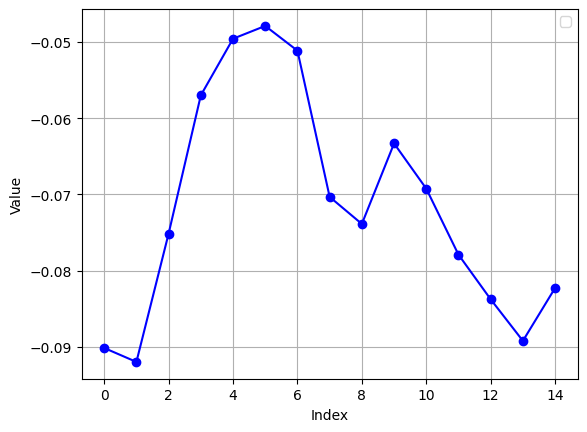

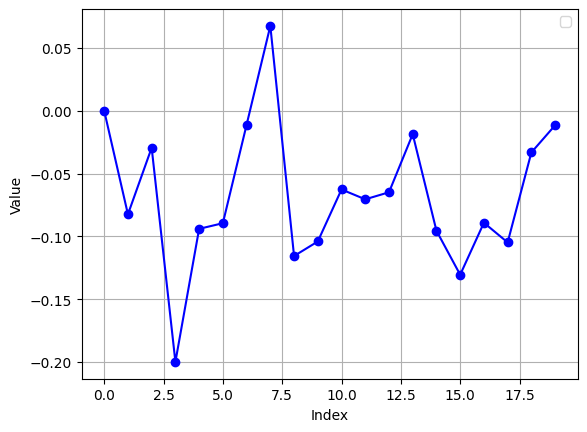

11521it [00:02, 3451.66it/s]

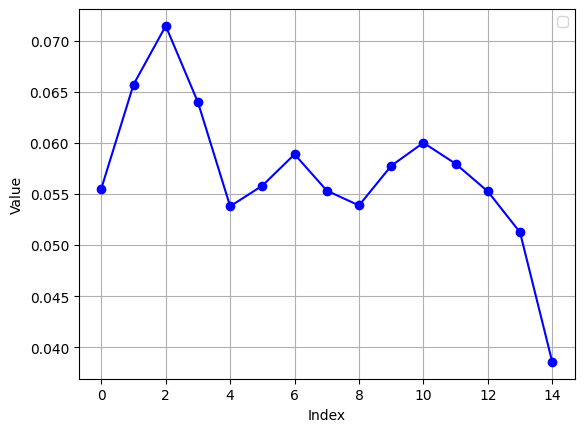

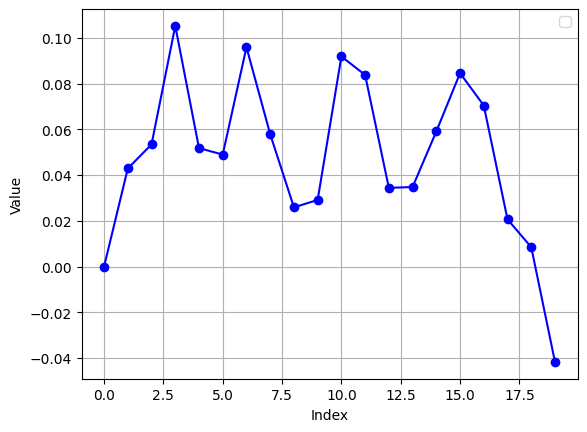

23879it [00:03, 8821.96it/s]

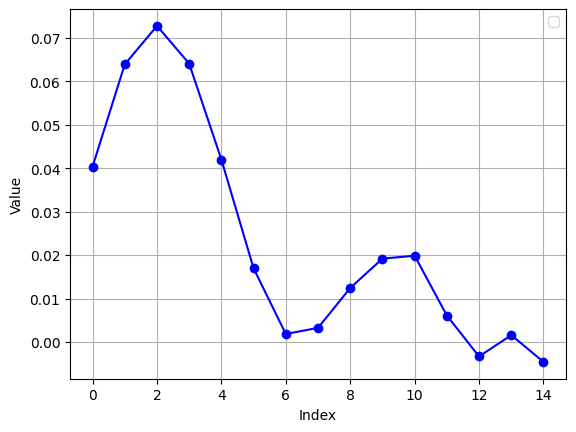

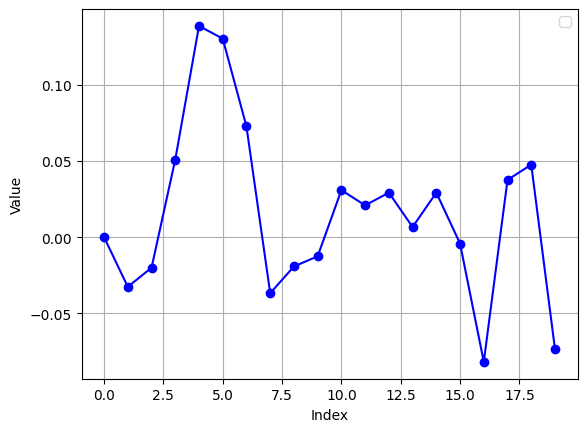

27427it [00:04, 7409.44it/s]

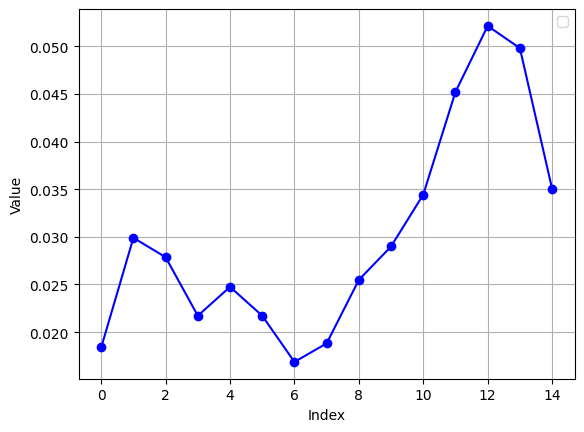

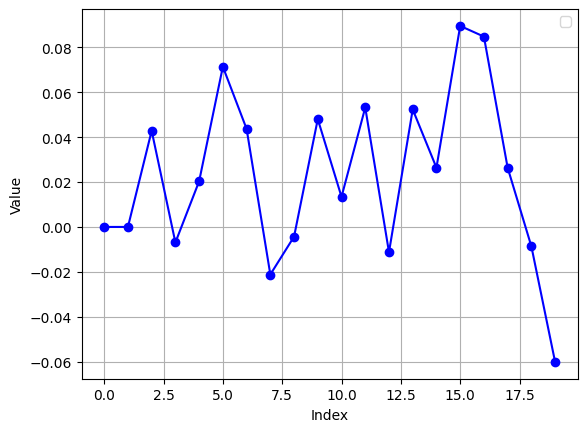

28254it [00:04, 5098.30it/s]

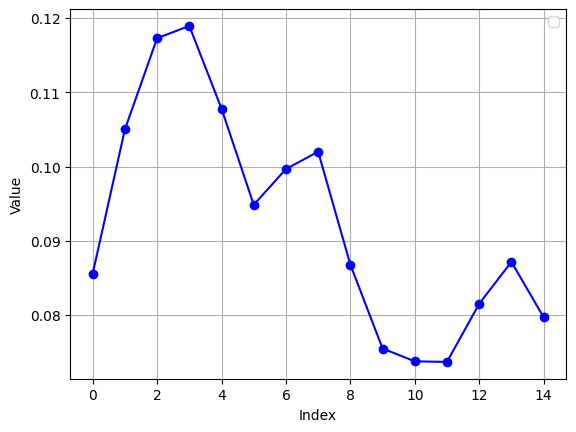

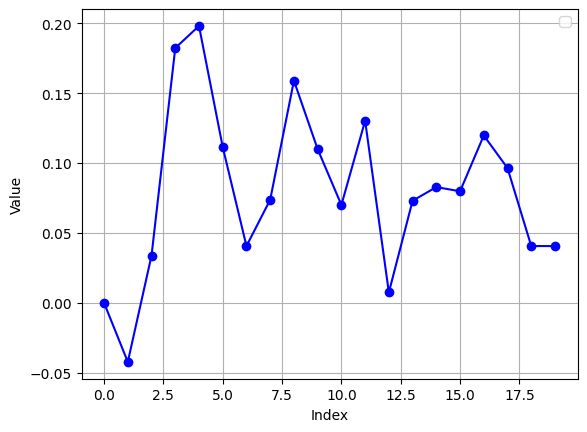

32465it [00:05, 6995.73it/s]

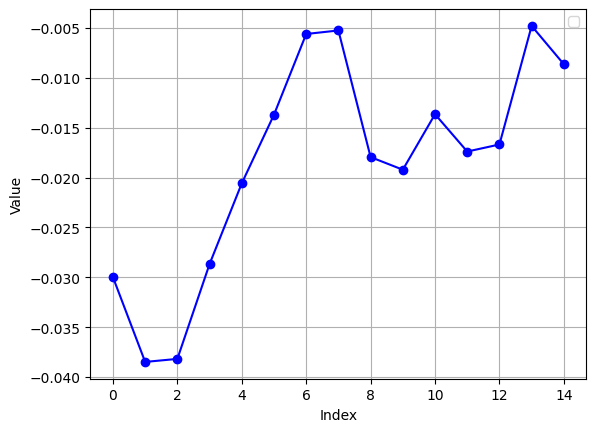

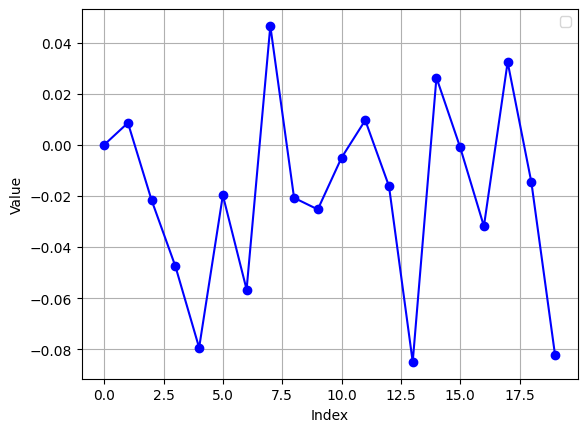

35033it [00:05, 6353.57it/s]

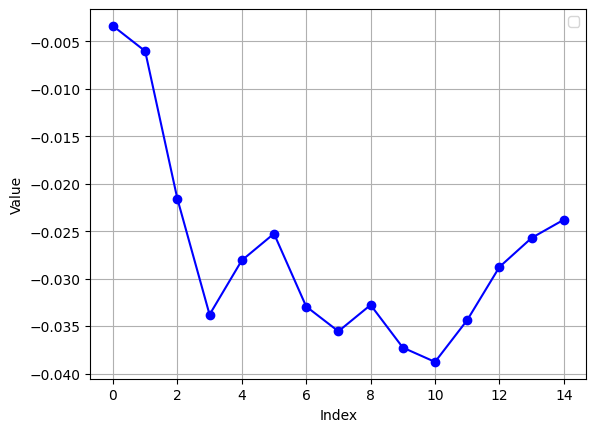

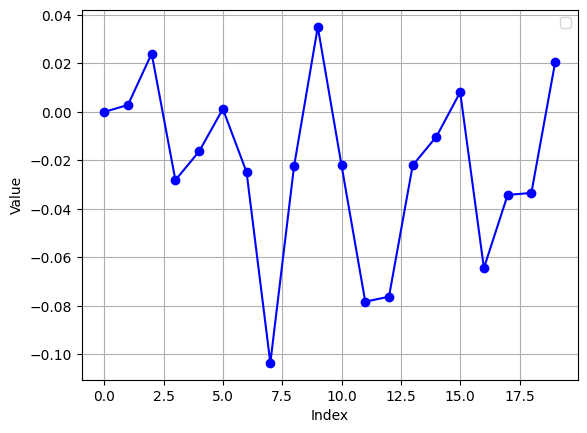

36701it [00:06, 5402.26it/s]

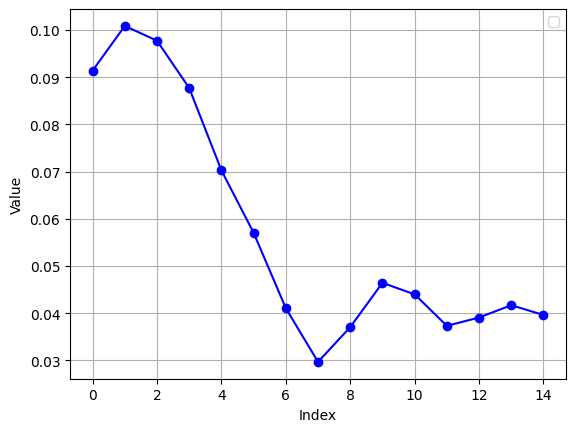

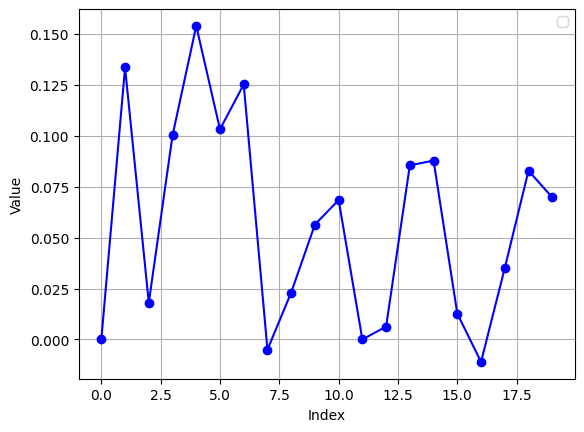

39186it [00:06, 5821.50it/s]

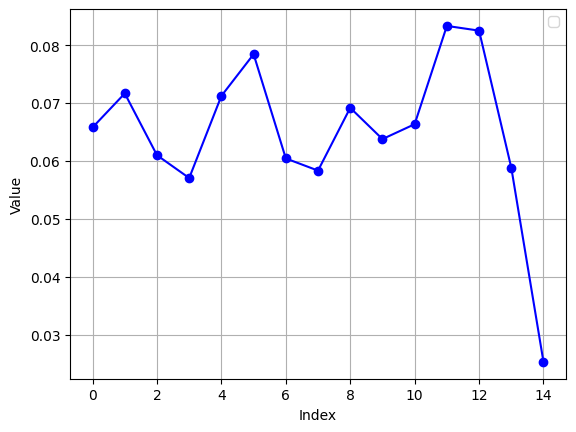

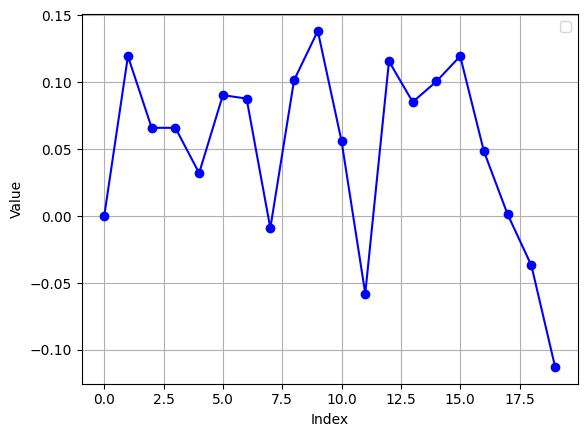

43590it [00:07, 7342.88it/s]

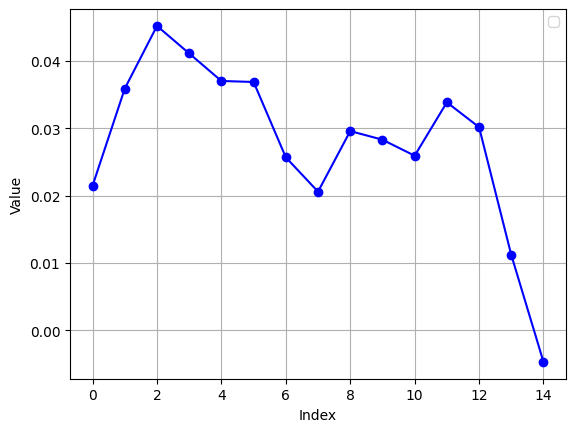

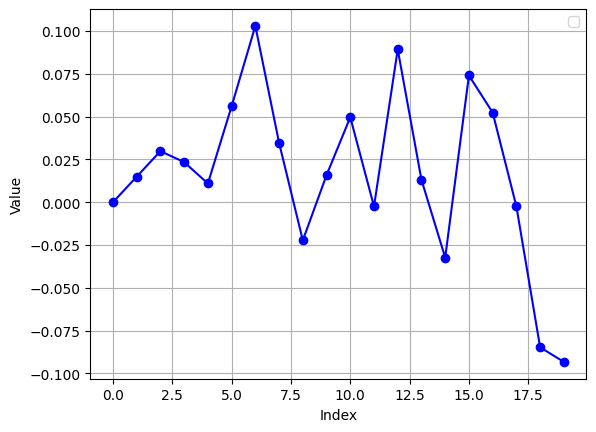

43733it [00:07, 5740.17it/s]


In [37]:
from tqdm import tqdm
mp = {

}
cnt1,cnt2,cnt3,cnt4,cnt5,cnt6,cnt7=0,0,0,0,0,0,0
for i,testdata in tqdm(enumerate(datas)):
    testdata = testdata['close'].to_numpy()
    testdata = (testdata-testdata[0])/testdata[0]*100
    t = testdata
    testdata = smooth(testdata)
    testdata = smooth(testdata,2)
    patternid = checkpattern(testdata)
    if patternid not in mp:
        mp[patternid]=[]
    mp[patternid].append(i)
    if patternid == "-1":
        plot(testdata)
        plot(t)
        cnt5+=1
        if cnt5==10:
            break

0


/tmp/ipykernel_1287401/600205071.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


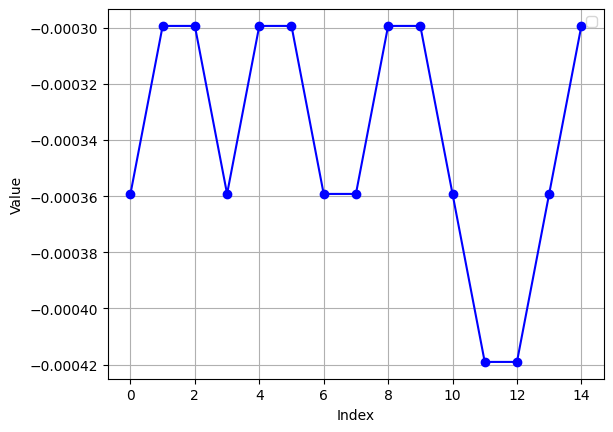

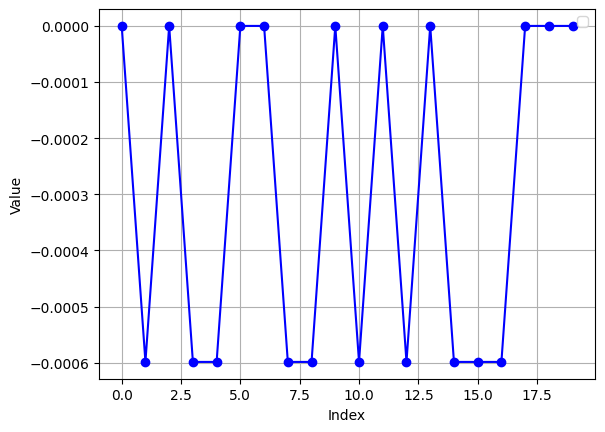

**************************
01


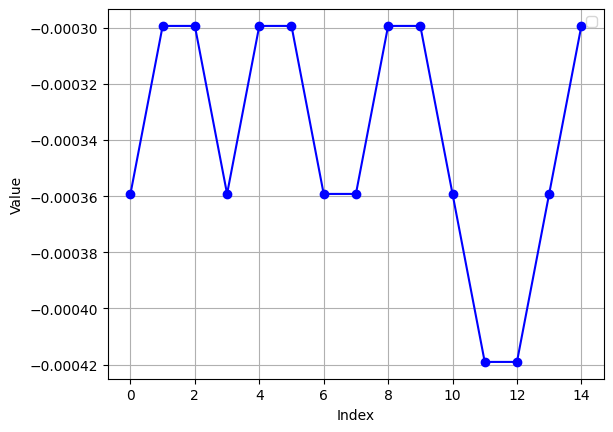

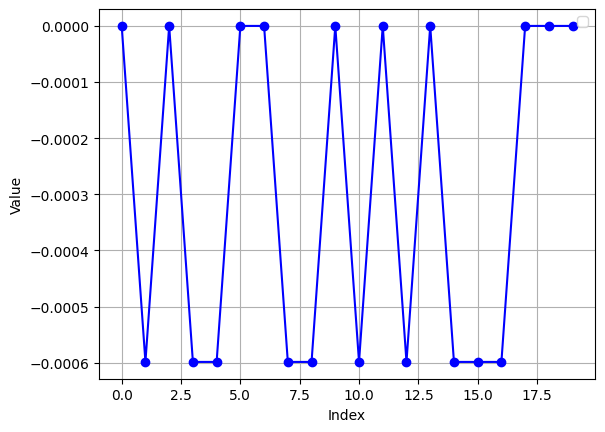

**************************
1


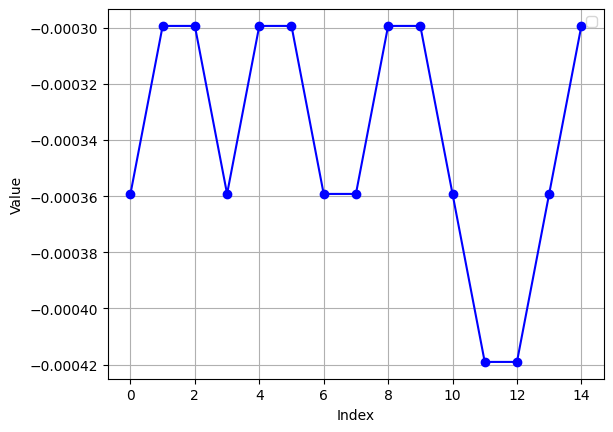

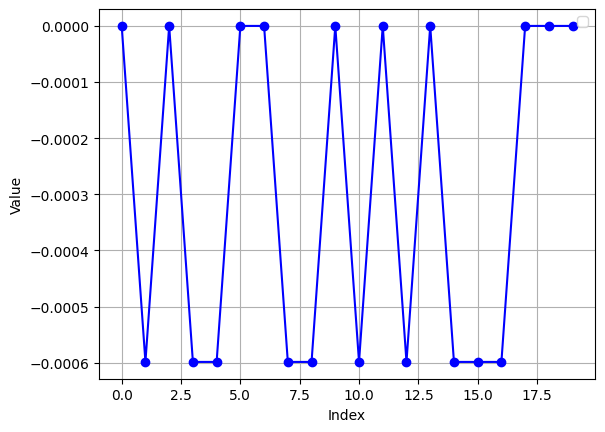

**************************
00


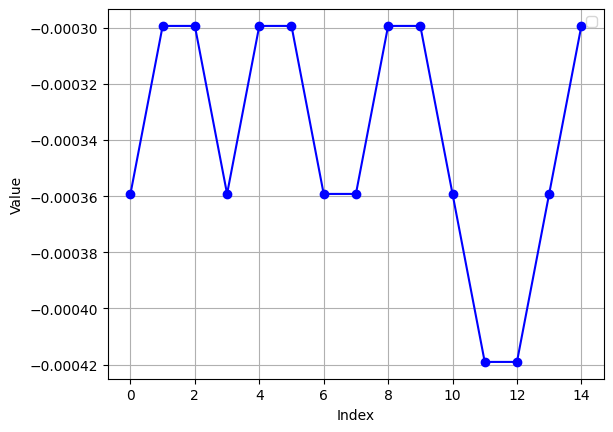

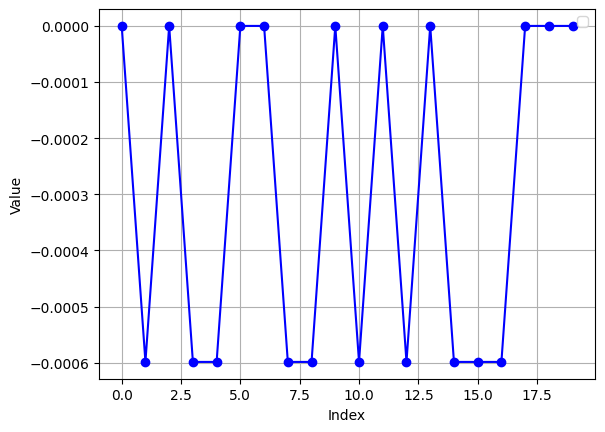

**************************
101


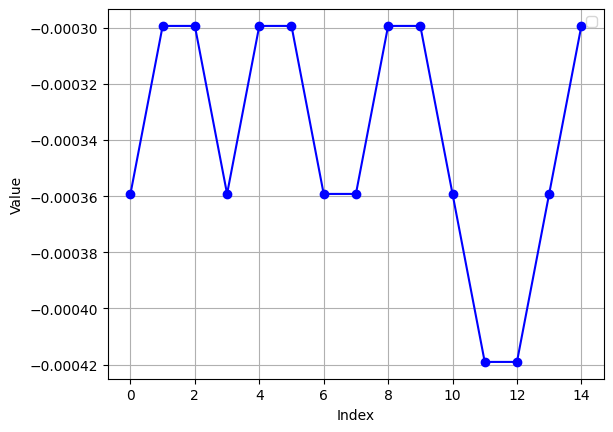

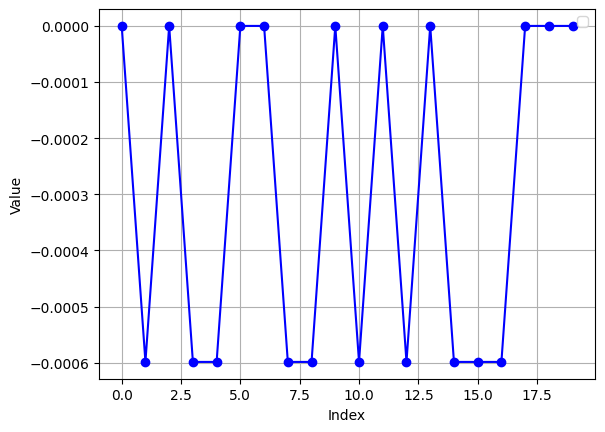

**************************
0101


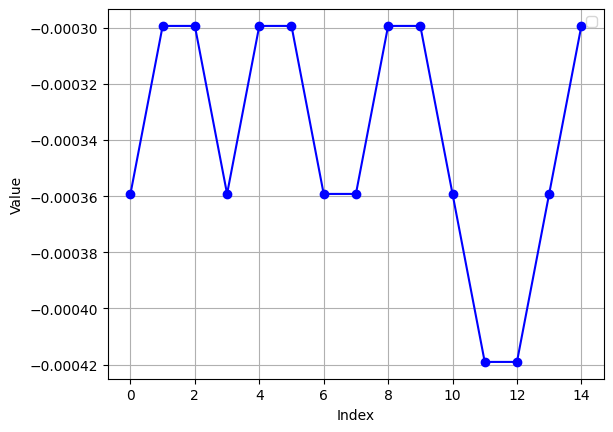

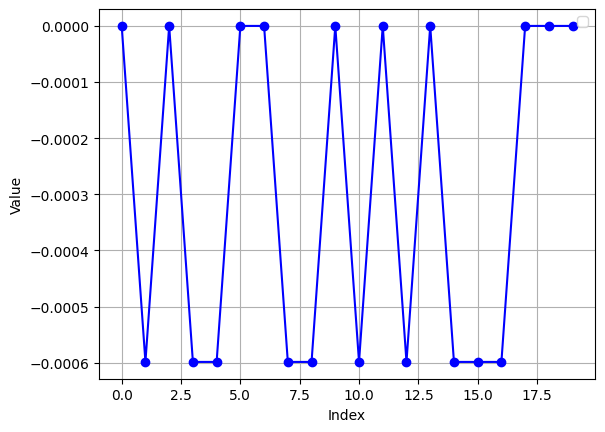

**************************
10


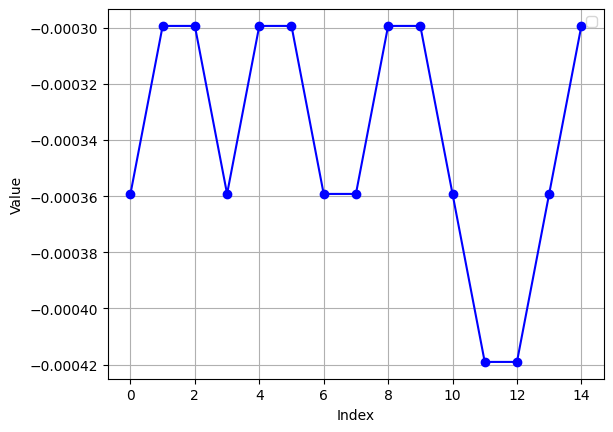

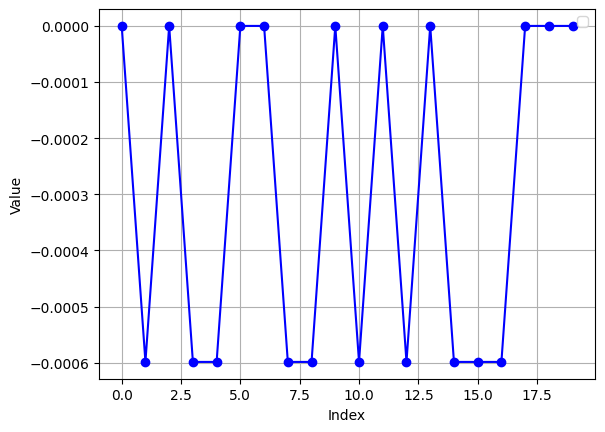

**************************
010


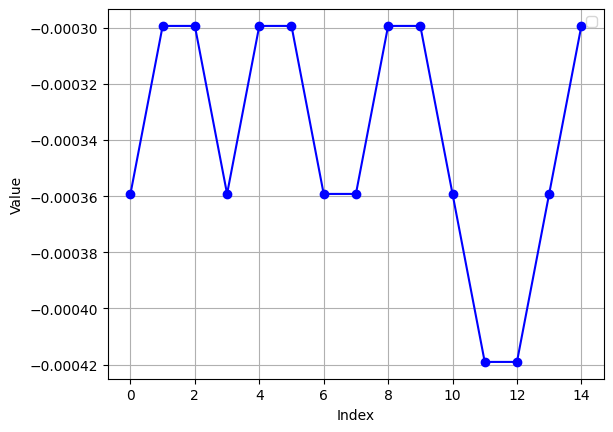

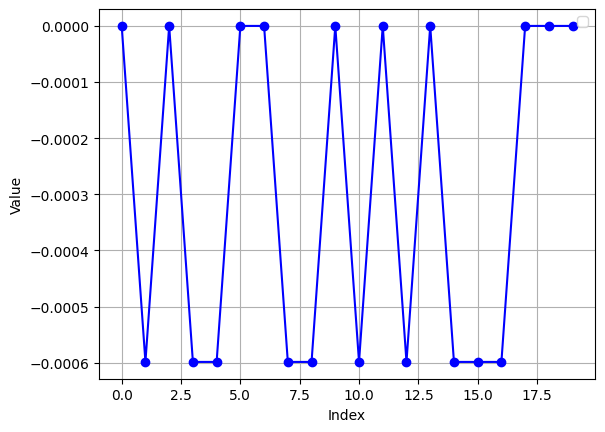

**************************
1010


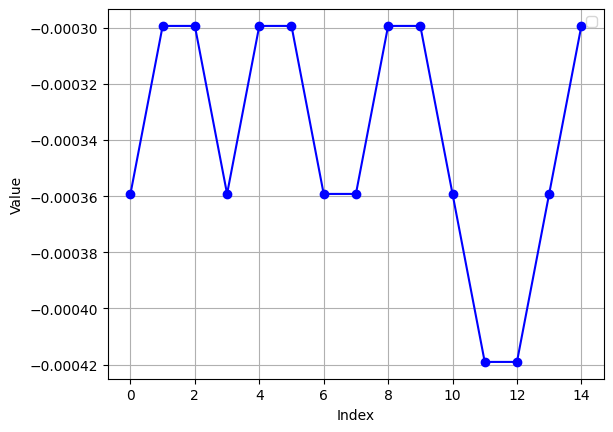

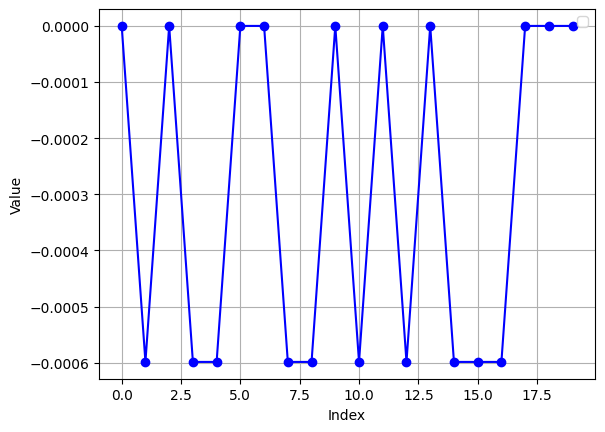

**************************
01010


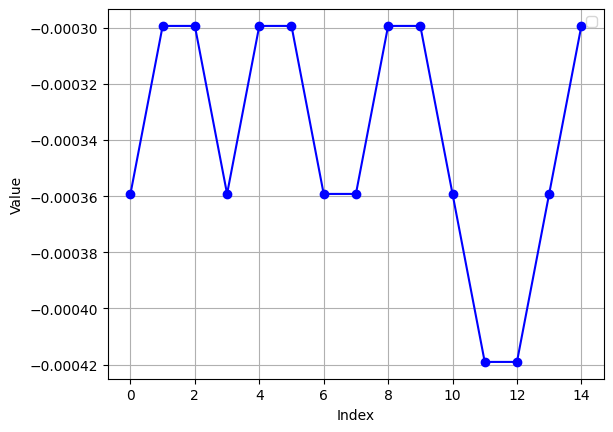

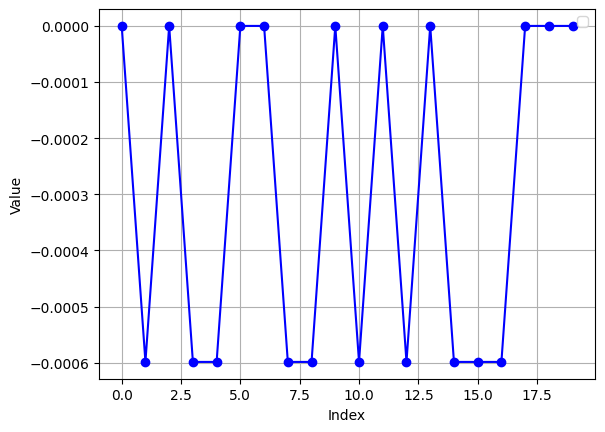

**************************
10101


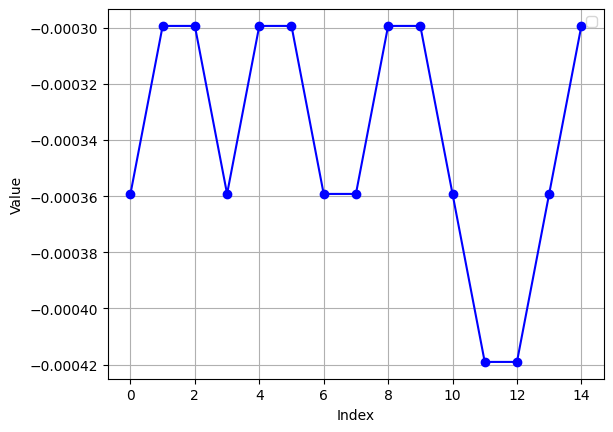

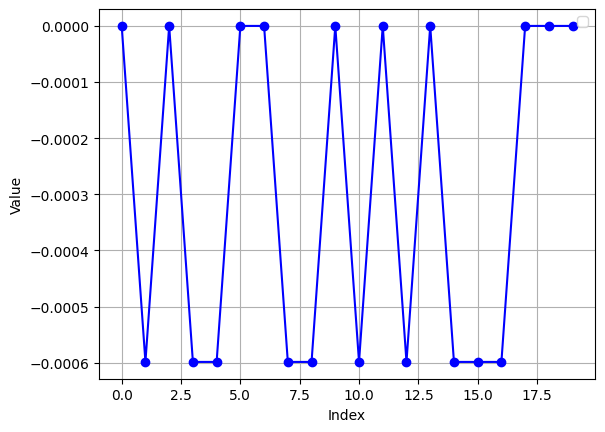

**************************
-1


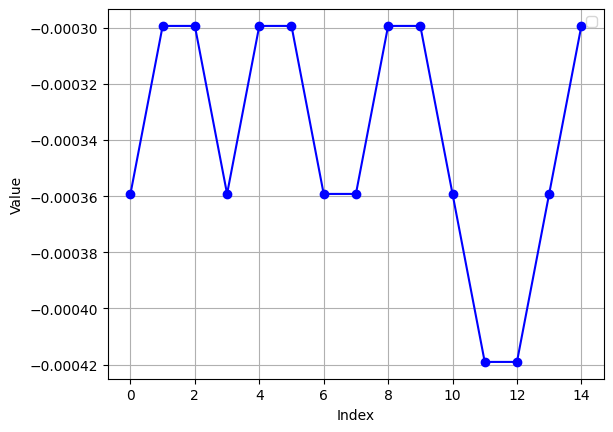

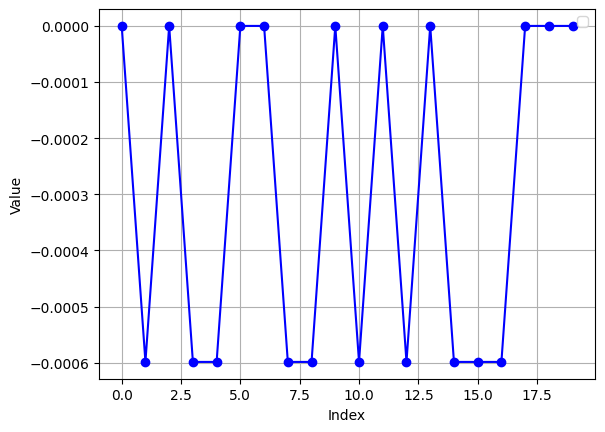

**************************


In [38]:
for k,v in mp.items():
    print(k)
    testdata = datas[random.sample(v,1)[0]]
    testdata

    testdata = datas[6896]['close'].to_numpy()
    testdata = (testdata-testdata[0])/testdata[0]*100
    t = testdata
    testdata = smooth(testdata)
    testdata = smooth(testdata,2)

    plot(testdata)
    plot(t)

    print("**************************") 
    

In [44]:
print({k:len(v) for k,v in mp.items()})


{'0': 7994, '01': 7849, '1': 7913, '00': 3479, '101': 3555, '0101': 753, '10': 7707, '010': 3563, '1010': 781, '01010': 70, '10101': 60, '-1': 10}


In [43]:
import json
ss = {
      "0":[indexs[id] for id in mp['0']],
      "1":[indexs[id] for id in mp['1']]
      
      }

with open("train_index",'w')as f:
    f.write(json.dumps(ss))